In [1]:
import sys
import os
current_dir = os.getcwd()  
project_root = os.path.dirname(current_dir)  
sys.path.insert(0, project_root) 
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE, mutual_info_regression
from src.config.config import Config
from src.data.data_loader import DataLoader
from src.models.model_evaluator import ModelEvaluator

def train_models(train: pd.DataFrame,val: pd.DataFrame,target_column: str):
    """训练模型流程
    Args:
        data_path: 可选的数据文件路径
    """
    model_evaluator.setup_experiment(
        train_size=Config.MODEL_CONFIG['train_size'],
        train_data=train,
        val_data = val,
        target_column = target_column,
        categorical_features = Config.FEATURE_CONFIG['categorical_columns']
    )

    # 训练模型并返回最佳模型字典
    return model_evaluator.train_top_models(n_models=Config.MODEL_CONFIG['n_top_models'])

def tune(models: dict):
    """模型调优和集成"""
    # 对top模型进行调优
    tuned_models = model_evaluator.tune_models(models)

    return tuned_models

def ensemble(models: dict):
    """模型集成"""
    # 对top模型进行集成
    blended_model = model_evaluator.ensemble_models(models)

    return blended_model    
    # 模型
    
def save_models(models: dict):

    model_evaluator.saved_models(models)

def select_features(train_data: pd.DataFrame, test_data: pd.DataFrame, 
                   time_test_data: pd.DataFrame, n_features: int = 15) -> tuple:
    """选择最重要的特征
    
    Args:
        train_data: 训练数据
        test_data: 测试数据
        time_test_data: 时间测试数据
        n_features: 要选择的特征数量，默认为15
        
    Returns:
        tuple: (处理后的训练集, 测试集, 时间测试集)
    """
    # 排除不需要的列
    target_transformed = f"{Config.DATA_CONFIG['target_column']}_{Config.FEATURE_CONFIG['target_transform_method']}"
    feature_cols = [col for col in train_data.columns 
                    if col not in [Config.DATA_CONFIG['target_column'], target_transformed,
                                 'Country Name', 'Year', 'Region', 'Income Group']]
    
    # 自动调整特征数量，确保不超过样本量的1/10
    sample_count = len(train_data)
    max_features = min(n_features, sample_count // 10)
    if max_features < n_features:
        print(f"警告: 样本量({sample_count})较小，特征数量已从{n_features}自动调整为{max_features}")
        n_features = max_features
    
    # 准备数据
    X = train_data[feature_cols]
    y = train_data[target_transformed]
    
    # 1. 基于模型的特征选择 (SelectFromModel)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    selector1 = SelectFromModel(rf_model, threshold='median')
    selector1.fit(X, y)
    model_selected_features = X.columns[selector1.get_support()].tolist()
    
    # 计算特征重要性分数
    rf_model.fit(X, y)
    model_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 2. 递归特征消除 (RFE)
    rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), 
                      n_features_to_select=n_features, step=1)
    rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_].tolist()
    
    # 计算RFE排名
    rfe_ranking = pd.DataFrame({
        'feature': feature_cols,
        'ranking': rfe_selector.ranking_
    }).sort_values('ranking')
    
    # 3. 基于互信息的特征选择 (mutual_info_regression)
    mi_scores = mutual_info_regression(X, y)
    mi_selected_features = pd.DataFrame({
        'feature': feature_cols,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False).head(n_features)['feature'].tolist()
    
    # 4. 添加LASSO特征选择 (适合小样本量)
    from sklearn.linear_model import LassoCV
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X, y)
    lasso_importance = np.abs(lasso.coef_)
    lasso_selected_features = pd.DataFrame({
        'feature': feature_cols,
        'importance': lasso_importance
    }).sort_values('importance', ascending=False).head(n_features)['feature'].tolist()
    
    # 统计每个特征被选中的次数（投票）
    feature_votes = {}
    for feature in feature_cols:
        feature_votes[feature] = 0
        if feature in model_selected_features:
            feature_votes[feature] += 1
        if feature in rfe_selected_features:
            feature_votes[feature] += 1
        if feature in mi_selected_features:
            feature_votes[feature] += 1
        if feature in lasso_selected_features:
            feature_votes[feature] += 1
    
    # 按投票数排序选择特征
    selected_features = pd.DataFrame({
        'feature': list(feature_votes.keys()),
        'votes': list(feature_votes.values())
    }).sort_values(['votes', 'feature'], ascending=[False, True]).head(n_features)['feature'].tolist()
    
    # 打印各方法选择的特征
    print("\n基于模型重要性选择的特征:")
    for i, row in model_importance.head(10).iterrows():
        print(f"{i+1}. {row['feature']} (重要性: {row['importance']:.4f})")
        
    print("\n基于递归特征消除选择的特征:")
    for i, feature in enumerate(rfe_selected_features[:10], 1):
        print(f"{i}. {feature} (排名: {rfe_ranking[rfe_ranking['feature']==feature]['ranking'].values[0]})")
        
    print("\n基于互信息选择的特征:")
    for i, feature in enumerate(mi_selected_features[:10], 1):
        mi_value = mi_scores[feature_cols.index(feature)]
        print(f"{i}. {feature} (互信息: {mi_value:.4f})")
        
    print("\n基于LASSO选择的特征:")
    for i, feature in enumerate(lasso_selected_features[:10], 1):
        lasso_value = lasso_importance[feature_cols.index(feature)]
        print(f"{i}. {feature} (LASSO系数: {lasso_value:.4f})")
    
    # 打印最终选择的特征
    print(f"\n最终选择的{len(selected_features)}个特征 (基于投票):")
    for i, feature in enumerate(selected_features, 1):
        votes = feature_votes[feature]
        print(f"{i}. {feature} (得票: {votes}/4)")
    
    # 更新数据集，保留目标变量和转换后的目标变量
    selected_columns = selected_features + [target_transformed] + ['Region', 'Income Group']
    train = train_data[selected_columns]
    test = test_data[selected_columns]
    # time_test = time_test_data[selected_columns]
    
    return train, test, pd.DataFrame()

In [2]:
# 示例用法
df = pd.read_csv(Path(Config.PATH_CONFIG['features_dir'])  / 'training_data.csv')
data_loader = DataLoader()
model_evaluator = ModelEvaluator()

# 划分数据集
train_data, val_data, country_test_data = data_loader.split_data_by_countries(
    df,
    train_size=Config.DATA_CONFIG['country_train_size'],
    val_size=Config.DATA_CONFIG['country_val_size'],
    random_state=Config.DATA_CONFIG['random_state']
)
# 数据太少 不划分时间序列了
# train_data, time_test_data = data_loader.split_data_by_time(train_data,
#     test_size=Config.DATA_CONFIG['time_test_size'])

time_test_data = pd.DataFrame()

# 数据分析
print('\n训练集统计信息:')
data_loader.analyze_datasets(train_data)
print('\n验证集统计信息:')
data_loader.analyze_datasets(val_data)
print('\n外部国家测试集统计信息:')
data_loader.analyze_datasets(country_test_data)
print('\n外部时间测试集统计信息:')
# data_loader.analyze_datasets(time_test_data)
#合并验证集和外部国家测试集作为测试集
test_data = pd.concat([val_data, country_test_data])
print('\n合并，作为测试集统计信息:')
data_loader.analyze_datasets(test_data)

train_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'train.csv'), index=False)
test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'test.csv'), index=False)
# time_test_data.to_csv(os.path.join(Config.PATH_CONFIG['data_dir'], 'time_test_data.csv'), index=False)


训练集统计信息:
总数据条数: 345
国家总数: 33
包含的国家: Austria, Belgium, Bosnia and Herzegovina, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Italy, Japan, Lithuania, Luxembourg, Montenegro, Netherlands, North Macedonia, Norway, Poland, Portugal, Romania, Serbia, Slovak Republic, Spain, Sweden, Turkiye, United Kingdom, United States

特征数量: 16
特征列表: GDP PPP 2017_log, GDP PPP 2017_log_growth_1y, GDP PPP/capita 2017_log, IW, IW_log, Population_log, Population_log_growth_1y, gdp_log_x_pop_log, gdp_pc_log2_x_urban, gdp_pc_log_squared, gdp_pc_log_x_urban, urban_pop_perc, year_relative, year_relative_x_Population_log, year_relative_x_gdp_pc_log, year_relative_x_urban_pop_perc

年份分布: 1990:2 | 1991:2 | 1992:2 | 1993:2 | 1994:2 | 1995:2 | 1996:1 | 1997:2 | 1998:2 | 1999:2 | 2000:2 | 2001:2 | 2002:2 | 2003:2 | 2004:28 | 2005:2 | 2006:26 | 2007:2 | 2008:29 | 2009:2 | 2010:29 | 2011:2 | 2012:32 | 2013:2 | 2014:33 | 2015:2 | 2016:33 | 2017:2 | 2018:33 | 201

In [3]:
# 排除不需要的列
feature_cols = [col for col in train_data.columns 
                if col not in [Config.DATA_CONFIG['target_column'], 'Country Name', 'Year']]

train = train_data[feature_cols]
test = test_data[feature_cols]
# time_test_data = time_test_data[feature_cols] 

target_column = Config.DATA_CONFIG['target_column']
method = Config.FEATURE_CONFIG['target_transform_method']
transformed_column = f'{target_column}_{method}'

In [4]:
# 使用特征选择方法
selected_features, test_selected, time_test_selected = select_features(train_data, test_data, time_test_data, n_features=10)

# 强制添加时间相关特征
time_features = [col for col in train_data.columns if any(term in col for term in 
                ['year', 'time', 'decade','change','country_specific', 'growth', 'acceleration'])]

for col in time_features:
    if col not in selected_features.columns:
        selected_features[col] = train_data[col]
        test_selected[col] = test_data[col]
        # time_test_selected[col] = time_test_data[col]
        print(f"强制添加时间特征: {col}")

# 使用增强后的特征集训练模型
train, test, time_test_data = selected_features, test_selected, time_test_selected


基于模型重要性选择的特征:
1. Population (重要性: 0.3656)
7. Population_log (重要性: 0.3445)
13. gdp_log_x_pop_log (重要性: 0.1787)
11. Population_log_growth_1y (重要性: 0.0214)
4. Urban population % (重要性: 0.0151)
5. GDP PPP 2017_log (重要性: 0.0123)
12. urban_pop_perc (重要性: 0.0123)
2. GDP PPP 2017 (重要性: 0.0109)
3. GDP PPP/capita 2017 (重要性: 0.0064)
15. gdp_pc_log2_x_urban (重要性: 0.0061)

基于递归特征消除选择的特征:
1. Population (排名: 1)
2. GDP PPP 2017 (排名: 1)
3. GDP PPP/capita 2017 (排名: 1)
4. Urban population % (排名: 1)
5. GDP PPP 2017_log (排名: 1)
6. Population_log (排名: 1)
7. gdp_pc_log_squared (排名: 1)
8. Population_log_growth_1y (排名: 1)
9. urban_pop_perc (排名: 1)
10. gdp_log_x_pop_log (排名: 1)

基于互信息选择的特征:
1. gdp_log_x_pop_log (互信息: 1.6496)
2. Population_log (互信息: 1.5979)
3. GDP PPP 2017_log (互信息: 1.4487)
4. Population (互信息: 1.3053)
5. Urban population % (互信息: 1.1506)
6. urban_pop_perc (互信息: 1.1505)
7. GDP PPP 2017 (互信息: 1.1292)
8. gdp_pc_log_x_urban (互信息: 1.0427)
9. gdp_pc_log2_x_urban (互信息: 1.0260)
10. GDP PPP/capita 2017 (互

In [5]:
# 训练模型
models = train_models(train,test,transformed_column)

,Description,Value
0,Session id,456
1,Target,IW_log
2,Target type,Regression
3,Original data shape,"(416, 18)"
4,Transformed data shape,"(416, 20)"
5,Transformed train set shape,"(345, 20)"
6,Transformed test set shape,"(71, 20)"
7,Ordinal features,1
8,Numeric features,15
9,Categorical features,2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.7058,0.8821,0.8772,-0.3326,0.0487,0.0404,0.0400
gbr,Gradient Boosting Regressor,0.7159,0.8606,0.8901,-0.3214,0.0495,0.0415,0.0500
catboost,CatBoost Regressor,0.7374,0.8793,0.9208,-0.1515,0.0523,0.0436,0.5700
ada,AdaBoost Regressor,0.7794,0.9176,0.9223,-0.1921,0.0510,0.0448,0.0300
rf,Random Forest Regressor,0.7786,0.9935,0.9356,-0.3967,0.0517,0.0446,0.0480
lightgbm,Light Gradient Boosting Machine,0.7974,0.9191,0.9448,-0.2726,0.0530,0.0463,0.0800
dt,Decision Tree Regressor,0.8551,1.3730,1.0570,-1.0920,0.0584,0.0488,0.0180
xgboost,Extreme Gradient Boosting,0.9189,1.5369,1.1567,-0.9425,0.0657,0.0529,0.1040
knn,K Neighbors Regressor,0.9175,1.4259,1.1670,-0.6163,0.0659,0.0544,0.0320
omp,Orthogonal Matching Pursuit,1.1158,1.8654,1.2896,-3.3556,0.0685,0.0642,0.6260


In [7]:
# 定义需要包含的模型简称集合
include_models = {'rf','xgboost','et','lightgbm','gbr','catboost'}

# 生成过滤后的有序字典
model_dict = {
    k: v for k, v in models.items()
    if k in include_models
}

In [8]:
print(f'当前调优模型: {", ".join(model_dict.keys())}')

# 调优
tune_models = tune(model_dict)

当前调优模型: et, gbr, catboost, rf, lightgbm, xgboost
当前调优模型: et , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0707,1.4559,1.2066,-0.2066,0.0647,0.0600
1,0.4604,0.4834,0.6952,0.8867,0.0449,0.0300
2,0.2635,0.1550,0.3937,0.9482,0.0241,0.0171
3,0.7166,0.9294,0.9641,0.3915,0.0505,0.0390
4,0.7484,0.7045,0.8393,-3.1304,0.0434,0.0406
Mean,0.6519,0.7456,0.8198,-0.2221,0.0455,0.0373
Std,0.2744,0.4376,0.2712,1.5122,0.0131,0.0141


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.6595,3.7824,1.9448,0.6705,0.1004,0.0881


当前调优模型: gbr , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9125,1.0663,1.0326,0.1163,0.0557,0.0517
1,0.6348,0.5684,0.7540,0.8667,0.0464,0.0390
2,0.4291,0.2936,0.5418,0.9019,0.0337,0.0279
3,0.7771,0.9244,0.9615,0.3948,0.0510,0.0435
4,0.6318,0.6278,0.7923,-2.6809,0.0412,0.0343
Mean,0.6771,0.6961,0.8164,-0.0802,0.0456,0.0393
Std,0.1617,0.2728,0.1719,1.3333,0.0076,0.0081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.6832,3.8340,1.9581,0.6660,0.1004,0.0894


当前调优模型: catboost , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9205,1.1599,1.0770,0.0387,0.0581,0.0524
1,0.7774,0.7986,0.8936,0.8127,0.0536,0.0470
2,0.5757,0.4186,0.6470,0.8601,0.0395,0.0372
3,0.6145,0.4777,0.6911,0.6873,0.0371,0.0349
4,0.6496,0.7452,0.8633,-3.3692,0.0453,0.0353
Mean,0.7076,0.7200,0.8344,-0.1941,0.0467,0.0413
Std,0.1262,0.2645,0.1542,1.6148,0.0080,0.0071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.6802,3.5804,1.8922,0.6881,0.0993,0.0917


当前调优模型: rf , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0308,1.4117,1.1882,-0.1700,0.0640,0.0584
1,0.6123,0.6555,0.8096,0.8463,0.0491,0.0377
2,0.2985,0.1723,0.4151,0.9424,0.0247,0.0192
3,0.7984,1.0074,1.0037,0.3404,0.0531,0.0443
4,0.7387,0.7223,0.8499,-3.2349,0.0441,0.0401
Mean,0.6957,0.7938,0.8533,-0.2551,0.0470,0.0399
Std,0.2406,0.4094,0.2564,1.5420,0.0130,0.0126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.7030,3.9742,1.9935,0.6537,0.1023,0.0900


当前调优模型: lightgbm , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9459,1.2193,1.1042,-0.0105,0.0597,0.0540
1,0.5110,0.3864,0.6216,0.9094,0.0383,0.0312
2,0.5687,0.4422,0.6650,0.8522,0.0420,0.0374
3,0.7182,0.7718,0.8785,0.4947,0.0463,0.0399
4,0.6378,0.6541,0.8088,-2.8351,0.0422,0.0346
Mean,0.6763,0.6948,0.8156,-0.1178,0.0457,0.0394
Std,0.1516,0.2972,0.1718,1.3976,0.0074,0.0079


[LightGBM] [Warning] feature_fraction is set=0.4011177472795284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4011177472795284
[LightGBM] [Warning] bagging_fraction is set=0.43368587731625413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43368587731625413
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.6304,3.6835,1.9192,0.6791,0.0996,0.0869


[LightGBM] [Warning] feature_fraction is set=0.4011177472795284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4011177472795284
[LightGBM] [Warning] bagging_fraction is set=0.43368587731625413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43368587731625413
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
当前调优模型: xgboost , 结果如下:


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8558,0.9564,0.9780,0.2074,0.0527,0.0485
1,0.5253,0.4577,0.6765,0.8927,0.0421,0.0325
2,0.4002,0.2429,0.4929,0.9188,0.0289,0.0250
3,0.7392,0.8127,0.9015,0.4679,0.0480,0.0416
4,0.6298,0.6764,0.8225,-2.9659,0.0431,0.0342
Mean,0.6300,0.6292,0.7743,-0.0958,0.0430,0.0364
Std,0.1592,0.2536,0.1725,1.4597,0.0080,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1.8483,4.4501,2.1095,0.6123,0.1084,0.0992


In [9]:
# 集成
models = ensemble(tune_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9513,1.1705,1.0819,0.0299,0.0583,0.0539
1,0.5701,0.5039,0.7099,0.8818,0.0441,0.0352
2,0.3897,0.2157,0.4644,0.9279,0.0281,0.0251
3,0.7043,0.7546,0.8687,0.5060,0.0459,0.0392
4,0.6602,0.6707,0.8189,-2.9321,0.0427,0.0359
Mean,0.6551,0.6631,0.7888,-0.1173,0.0438,0.0379
Std,0.1832,0.3135,0.2023,1.4439,0.0096,0.0093


[LightGBM] [Warning] feature_fraction is set=0.4011177472795284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4011177472795284
[LightGBM] [Warning] bagging_fraction is set=0.43368587731625413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43368587731625413
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
1,Gradient Boosting Regressor,0.6771,0.6961,0.8164,-0.0802,0.0456,0.0393,0.3980
5,Extreme Gradient Boosting,0.6300,0.6292,0.7743,-0.0958,0.0430,0.0364,0.0540
6,Voting Regressor,0.6551,0.6631,0.7888,-0.1173,0.0438,0.0379,0.2100
4,Light Gradient Boosting Machine,0.6763,0.6948,0.8156,-0.1178,0.0457,0.0394,0.0600
2,CatBoost Regressor,0.7076,0.7200,0.8344,-0.1941,0.0467,0.0413,0.4480
0,Extra Trees Regressor,0.6519,0.7456,0.8198,-0.2221,0.0455,0.0373,0.0360
3,Random Forest Regressor,0.6957,0.7938,0.8533,-0.2551,0.0470,0.0399,0.0440



------------------------------
正在分析模型: ET
------------------------------


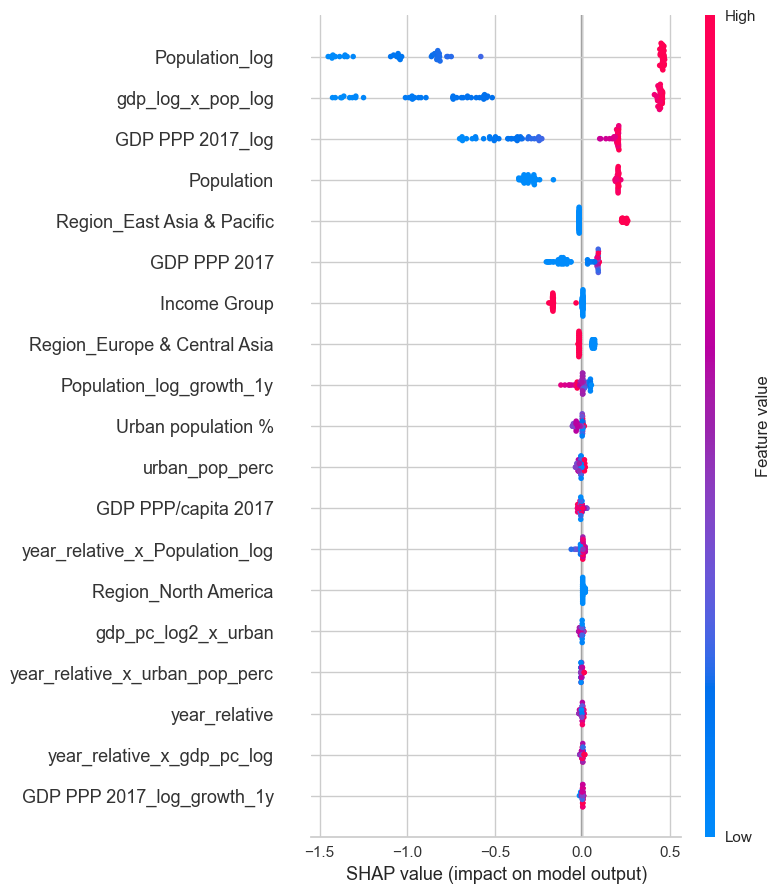

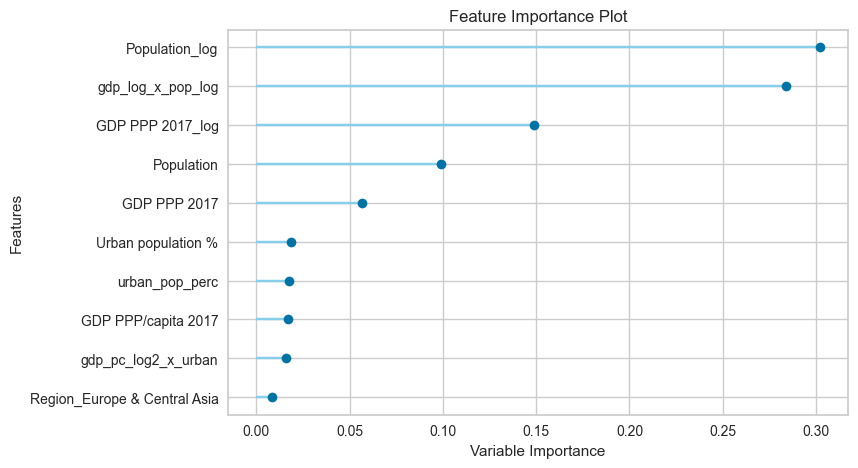


------------------------------
正在分析模型: GBR
------------------------------
gbr 不支持SHAP分析

------------------------------
正在分析模型: CATBOOST
------------------------------


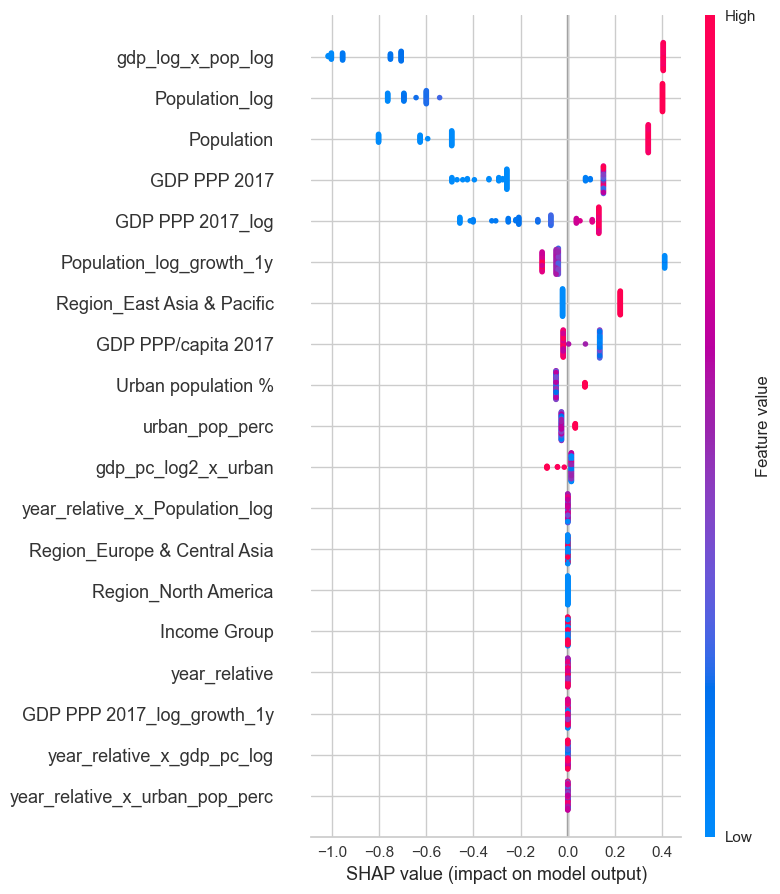

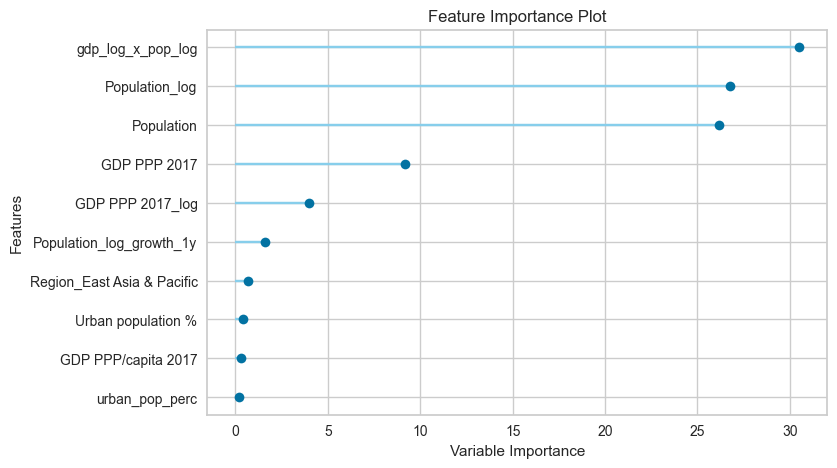


------------------------------
正在分析模型: RF
------------------------------


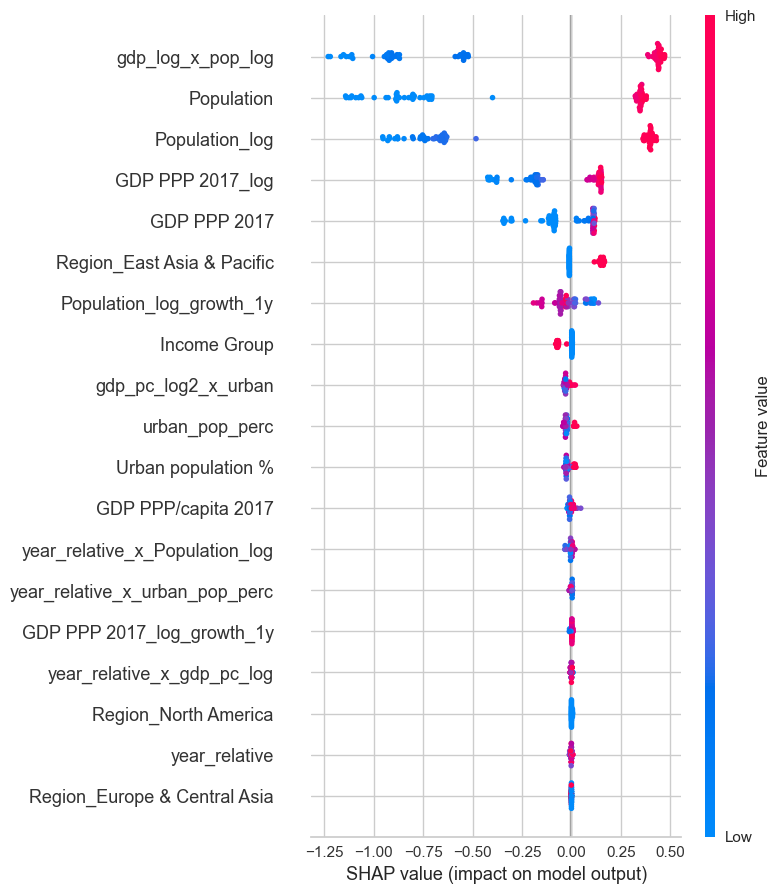

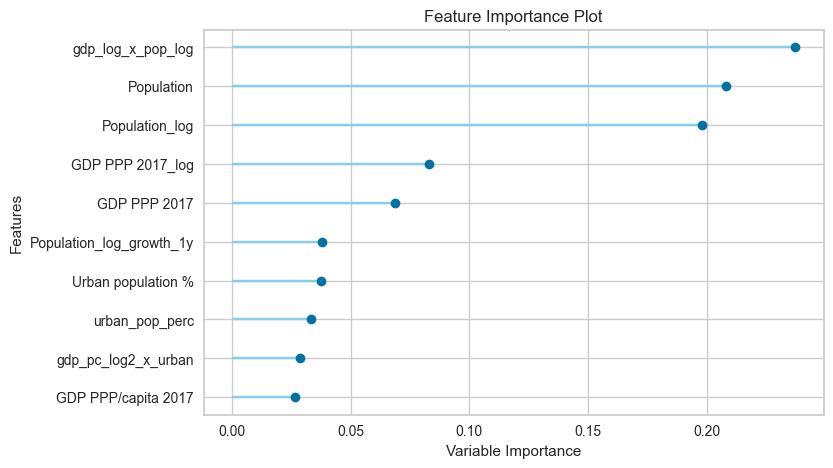


------------------------------
正在分析模型: LIGHTGBM
------------------------------


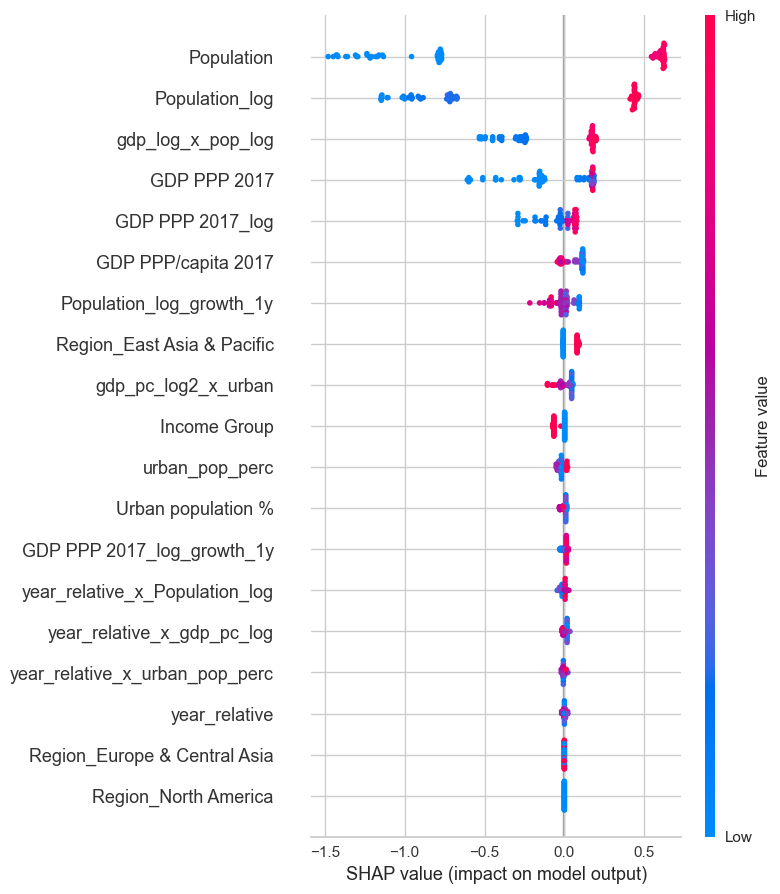

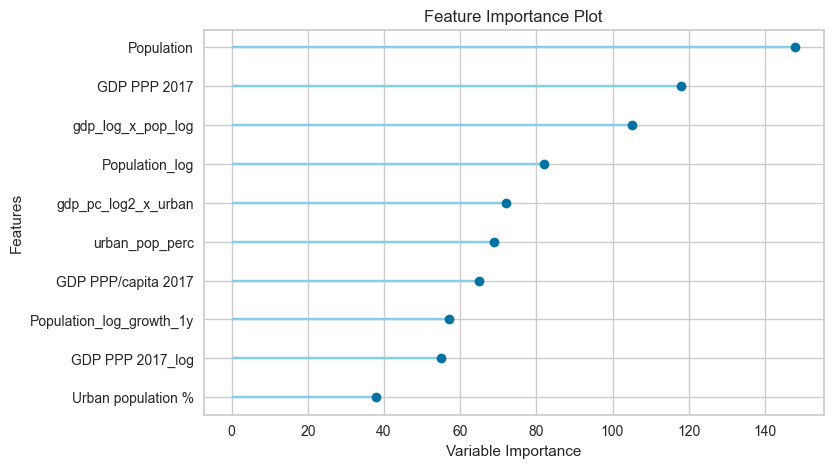


------------------------------
正在分析模型: XGBOOST
------------------------------


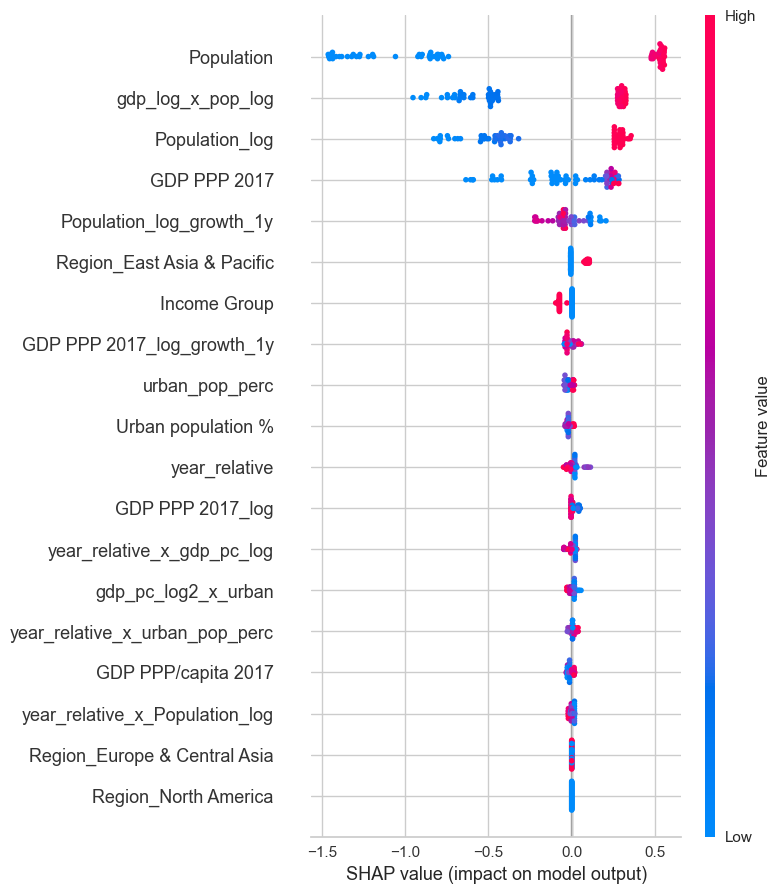

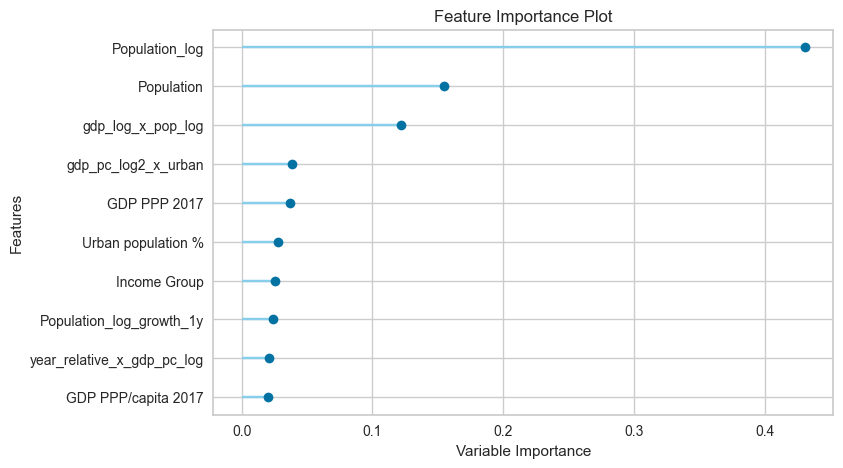


------------------------------
正在分析模型: BLEND
------------------------------
blend 不支持SHAP分析


In [10]:
for model_name, model in models.items():
    print(f"\n{'-'*30}")
    print(f"正在分析模型: {model_name.upper()}")
    print(f"{'-'*30}")
    
    # SHAP值解释（需要安装shap包）
    try:
        interpret_model(model)
        plot_model(model, plot = 'feature')
    except:
        print(f"{model_name} 不支持SHAP分析")

In [ ]:
# # 定义需要包含的模型简称集合
# include_models = {'xgboost','et','catboost'}

# # 生成过滤后的有序字典
# seleced_model_dict = {
#     k: v for k, v in tune_models.items()
#     if k in include_models
# }
# # 集成
# seleced_models = ensemble(seleced_model_dict)

In [11]:
seleced_models = models
save_model = save_models(seleced_models)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
